## BiLSTM

https://keras.io/examples/nlp/bidirectional_lstm_imdb/

In [ ]:
# Setup 
import numpy as np
import warnings

# Ignore FutureWarning from NumPy
warnings.simplefilter(action = 'ignore', category = FutureWarning)

from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from sklearn.metrics import f1_score, classification_report


max_features = 20000  # Use top 20k words
max_len = 200 # Use first 200 words of each movie review



# Input for variable-length sequences of integers
inputs = keras.Input(shape = (None,), dtype = "int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences = True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Add a classifier
outputs = layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,757,761
Trainable params: 2,757,761
Non-train

In [ ]:
# Load the IMDB movie review sentiment data
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(
    num_words = max_features, seed = 123)
print(len(x_train), "Training sequences")
print(len(x_test), "Test sequences")

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen = max_len)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen = max_len)

17473536/17464789 [==============================] - 0s 0us/step
25000 Training sequences
25000 Test sequences


In [ ]:
# Split into training and validation for fair comparison with other methods
# We split the data in the same sets than in the other model implementations
np.random.seed(123)
val_ix = np.random.randint(0, 24999, 5000)
x_val = x_train[val_ix]
y_val = y_train[val_ix]

In [ ]:
# Train and evaluate the model
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
history = model.fit(x_train, 
                    y_train, 
                    batch_size = 32, 
                    epochs = 5, 
                    validation_data = (x_val, y_val))

Epoch 1/5
782/782 [==============================] - 42s 41ms/step - loss: 0.4001 - accuracy: 0.8189 - val_loss: 0.2378 - val_accuracy: 0.9260
Epoch 2/5
782/782 [==============================] - 31s 40ms/step - loss: 0.2157 - accuracy: 0.9176 - val_loss: 0.1081 - val_accuracy: 0.9656
Epoch 3/5
782/782 [==============================] - 31s 39ms/step - loss: 0.1333 - accuracy: 0.9519 - val_loss: 0.0725 - val_accuracy: 0.9814
Epoch 4/5
782/782 [==============================] - 31s 40ms/step - loss: 0.0836 - accuracy: 0.9724 - val_loss: 0.0616 - val_accuracy: 0.9894
Epoch 5/5
782/782 [==============================] - 31s 39ms/step - loss: 0.0625 - accuracy: 0.9792 - val_loss: 0.0293 - val_accuracy: 0.9916


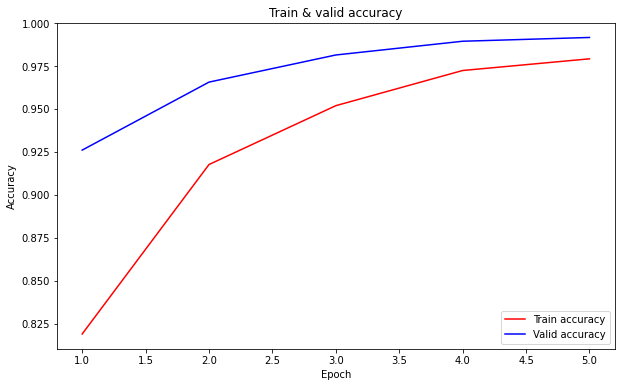

In [ ]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10.0, 6.0)
plt.plot(epochs, acc, '-r', label = 'Train accuracy')
plt.plot(epochs, val_acc, '-b', label = 'Valid accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train & valid accuracy')
plt.legend(loc = 4)
plt.show()

Both training and validation accuracies are suspiciously high.

In [ ]:
# Get validation accuracy + loss
scores = model.evaluate(x_val, y_val, batch_size = 32, verbose = 0)
print('Validation loss: %.4f' % scores[0])
print('Validation accuracy: %.4f' % scores[1])

Validation loss: 0.0293
Validation accuracy: 0.9916


This is a surprisingly good (and suspicious) result. Let's see if the model generalizes to the remaining data of the dataset that we haven't used yet.

In [ ]:
# Predict test set
yhat_class_info = model.predict(x_test, verbose = 0)
yhat_class_info = np.concatenate([1 - yhat_class_info, yhat_class_info], axis = 1)
yhat_class_info = np.argmax(yhat_class_info, axis = 1)

# Classification report
print("Classification Report")
print(classification_report(y_test, yhat_class_info))

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     12500
           1       0.85      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



The model does not generalize well on the test data. There is some overfitting during training. The source of this overfitting is unclear since we implemented a droupout layer that should avoid this problem